In [9]:
#import all libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

#ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [33]:
# open the cleaned datasets from the cleaned_datasets folder
movies = pd.read_csv('cleaned_datasets/movies_clean.csv')
characters = pd.read_csv('cleaned_datasets/characters_clean.csv')
actors_info = pd.read_csv('cleaned_datasets/actors_info_clean.csv')
actors_list = pd.read_csv('cleaned_datasets/actors_list_clean.csv')

# How awards influence the movies?

For this, let's try to first see some general trends by plotting movies with nonimated cast and those without.

In [36]:
# add the average fame, liked, disliked and neutral scores from the characters dataframe per movie to the movies dataframe
values = characters.groupby('freebase_movie_id',as_index=False).mean()
movies = pd.merge(movies, values[['freebase_movie_id','Fame','Liked','Disliked','Neutral']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies = movies.drop(['freebase_movie_id'], axis=1)
movies.head()

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,averageRating,numVotes,average_award_cumcount,average_movies_cumcount,award_cumcount,movies_cumcount,Fame,Liked,Disliked,Neutral
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,4.9,56894.0,0.0,4.529412,0.0,77.0,13.705882,9.117647,1.117647,3.411765
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,5.6,40.0,0.0,0.500000,0.0,2.0,0.000000,0.000000,0.000000,0.000000
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,5.9,623.0,0.0,1.666667,0.0,5.0,0.000000,0.000000,0.000000,0.000000
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,6.8,16.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,6.8,2268.0,0.0,3.750000,0.0,15.0,15.250000,9.000000,1.250000,4.750000


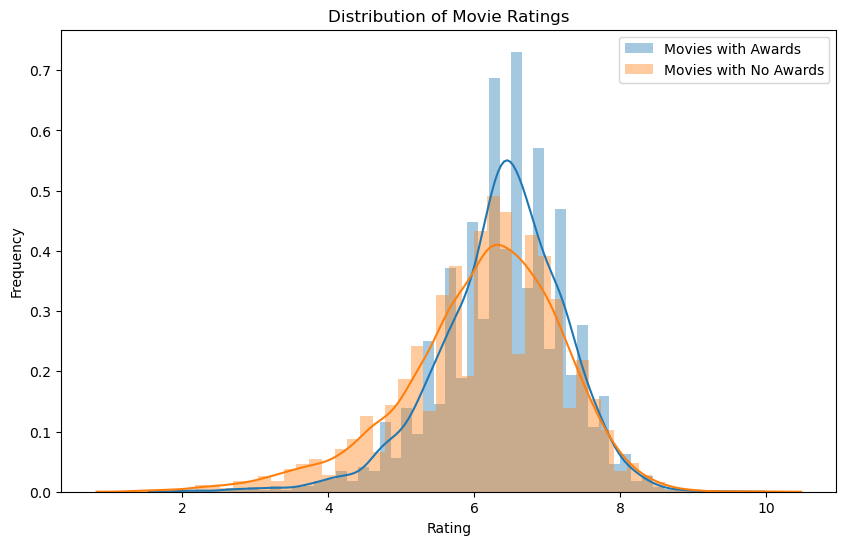

In [10]:
# split the movies into two dataframes, one for the movies that have an award cumcount and one for the movies with no awards
movies_awards = movies[movies['award_cumcount'] > 0]
movies_no_awards = movies[movies['award_cumcount'] == 0]

#plot the ratings distribution for movies both movies with and without awards on the same plot
plt.figure(figsize=(10,6))
sns.distplot(movies_awards['averageRating'], label='Movies with Awards')
sns.distplot(movies_no_awards['averageRating'], label='Movies with No Awards')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

As we can see, with out first look it seems like the distribution of ratings is pretty similar between both groups.

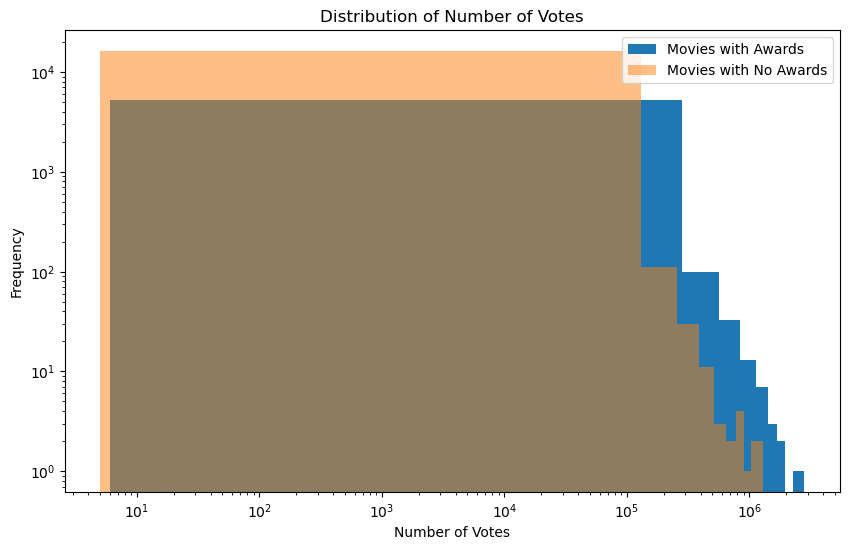

In [23]:
# lets now look at the distribution of the number of votes for both types of movies using a histogram
plt.figure(figsize=(10,6))
plt.hist(movies_awards['numVotes'], label='Movies with Awards')
plt.hist(movies_no_awards['numVotes'], label='Movies with No Awards', alpha=0.5)
plt.title('Distribution of Number of Votes')
plt.xlabel('Number of Votes')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Frequency')
plt.legend()



As we can see, the awarded casts produced movies with a much higher number of votes, maybe having a high number of votes increases your rating?

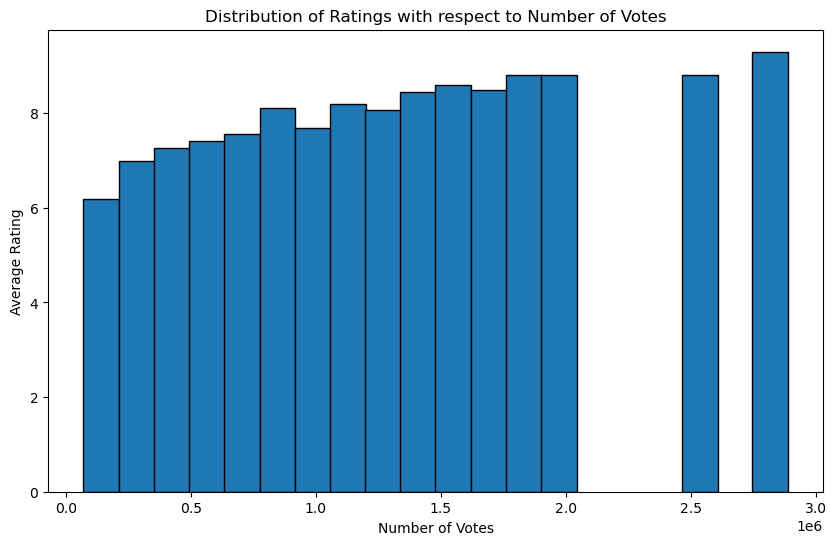

In [65]:
# lets now look at the distribution of the number of votes per rating for both types of movies using a histogram

# Calculate the mean of 'averageRating' for each bin
bin_means = movies.groupby(pd.cut(movies['numVotes'], bins=20))['averageRating'].mean()
bin_midpoints = [(bin.left + bin.right) / 2 for bin in bin_means.index]
bin_width = bin_means.index[1].left - bin_means.index[0].left

# Plotting the histogram with mean values
plt.figure(figsize=(10,6))
plt.bar(bin_midpoints, bin_means.values, edgecolor='black', align='edge', width=bin_width)

# Adding labels and title
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.title('Distribution of Ratings with respect to Number of Votes')

# Show the plot
plt.show()



Looks like a trend!

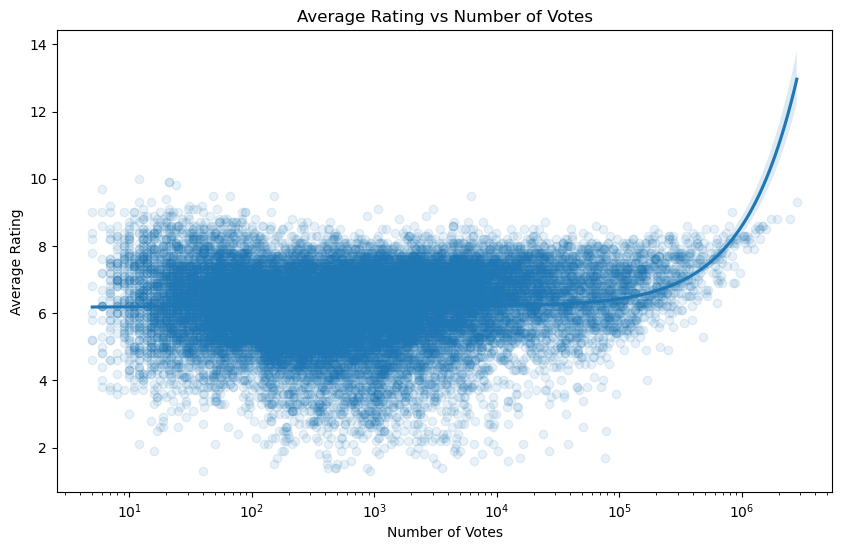

In [72]:
# lets now do a regression plot of the average rating vs the number of votes for both types of movies
plt.figure(figsize=(10,6))
sns.regplot(x='numVotes', y='averageRating', data=movies,scatter_kws={'alpha':0.1})
# make the scatter points more transparent so we can see the density of the points
plt.title('Average Rating vs Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.xscale('log')


In [75]:
#probably would be nice to normalize the number of votes
#TODO check regression with awards and without awards, see if the difference is significant

# ols regression of ratings vs log(number of votes) for movies
model = ols('averageRating ~ np.log(numVotes)', movies).fit()
print(model.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     341.5
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           9.61e-76
Time:                        17:37:32   Log-Likelihood:                -37831.
No. Observations:               25515   AIC:                         7.567e+04
Df Residuals:                   25513   BIC:                         7.568e+04
Df Model:                           1                                         
Covariance Type:            nonrobust  

# Time Analysis of awards

# Popularity matching